In [2]:
import os
import time
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm



import opensmile


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
import torch.nn.functional as F

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout
from keras.models import Model, Sequential
from keras.optimizers import SGD




In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [18]:
def one_hot_encoder(y):
    enc = OneHotEncoder(sparse_output=False)  
    return enc.fit_transform(y.reshape(-1, 1)) 


def normalization(X, mean, std):
    return (X-mean)/std

In [1]:
speech_unprocessed_path = r'data/Audio_Speech_Actors_01-24/*/*.wav'
song_unprocessed_path = r'data/Audio_Song_Actors_01-24/*/*.wav'

speech_dataset_path = "data/speech_dataset.npy"
song_dataset_path = "data/song_dataset.npy"

In [4]:
def process_dataset(data_path, save_path):

    files = glob(data_path)

    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    extracted_features = smile.process_files(files)

    x_ = extracted_features.values
    y_ = np.array([int(os.path.basename(path).split('-')[2]) for path in files])

    y_reshaped = y_[:, np.newaxis] 
    speech_dataset = np.concatenate((x_, y_reshaped), axis=1)

    np.save(save_path, speech_dataset)
    return np.load(save_path)

process_dataset(speech_unprocessed_path, speech_dataset_path)
process_dataset(song_unprocessed_path, song_dataset_path)



array([[ 3.20263786e+01,  4.23245728e-02,  3.11146488e+01, ...,
         4.65268731e-01, -3.80827827e+01,  1.00000000e+00],
       [ 3.22532959e+01,  3.75403874e-02,  3.12140598e+01, ...,
         4.48131889e-01, -3.62435303e+01,  1.00000000e+00],
       [ 3.25768166e+01,  1.33287504e-01,  3.10158653e+01, ...,
         4.51725602e-01, -3.78288574e+01,  1.00000000e+00],
       ...,
       [ 4.44739647e+01,  3.61195505e-02,  4.34327240e+01, ...,
         4.86908585e-01, -3.15463219e+01,  6.00000000e+00],
       [ 4.47922134e+01,  5.01109287e-02,  4.32589912e+01, ...,
         4.31302935e-01, -3.15310917e+01,  6.00000000e+00],
       [ 4.41322784e+01,  7.11850077e-02,  4.35137901e+01, ...,
         4.26455140e-01, -2.93001766e+01,  6.00000000e+00]])

In [6]:
def get_dataset(path):
    dataset = np.load(path)
    x = dataset[:, :-1]
    y = dataset[:,-1]
    return x, y



In [7]:
x_speech, y_speech = get_dataset(speech_dataset_path)
x_song, y_song = get_dataset(song_dataset_path)

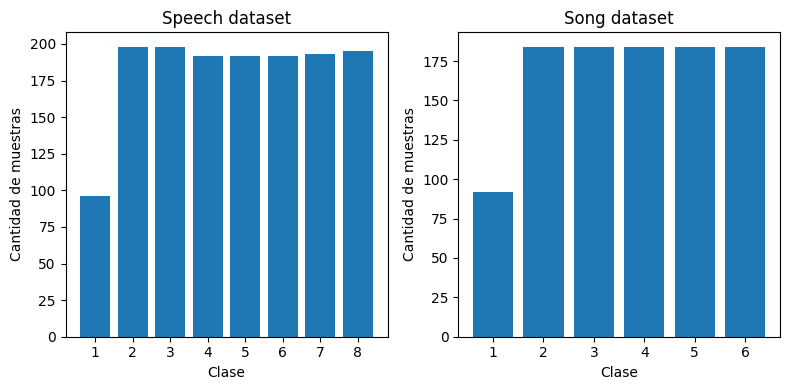

In [7]:
classes_speech, classes_count_speech = np.unique(y_speech, return_counts=True)
classes_song, classes_count_song = np.unique(y_song, return_counts=True)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 

axs[0].bar(classes_speech, classes_count_speech)
axs[0].set_title('Speech dataset')
axs[0].set_xlabel('Clase')
axs[0].set_ylabel('Cantidad de muestras')
axs[0].set_xticks(classes_speech) 

axs[1].bar(classes_song, classes_count_song)
axs[1].set_title('Song dataset')
axs[1].set_xlabel('Clase')
axs[1].set_ylabel('Cantidad de muestras')
axs[1].set_xticks(classes_song)

plt.tight_layout()
plt.show()

#NOTE: There is no strong intensity for the 'neutral' emotion.

In [27]:
print(np.unique(y_speech))
print(np.unique(y_song))

# y_speech = y_speech.astype(int)
# y_song = y_song.astype(int)

[1. 2. 3. 4. 5. 6. 7. 8.]
[1. 2. 3. 4. 5. 6.]


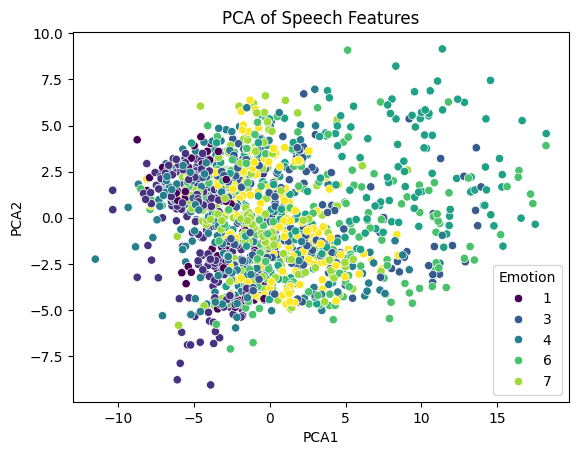

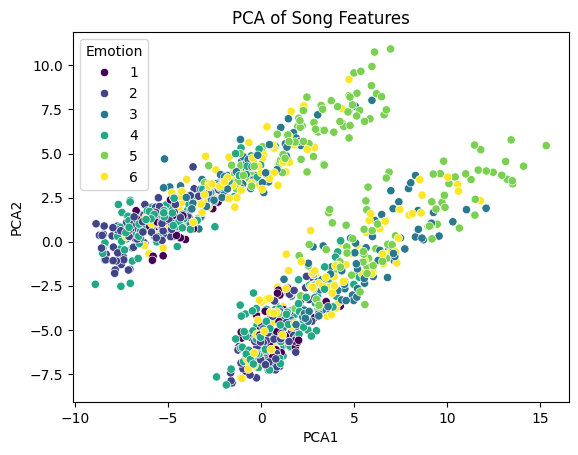

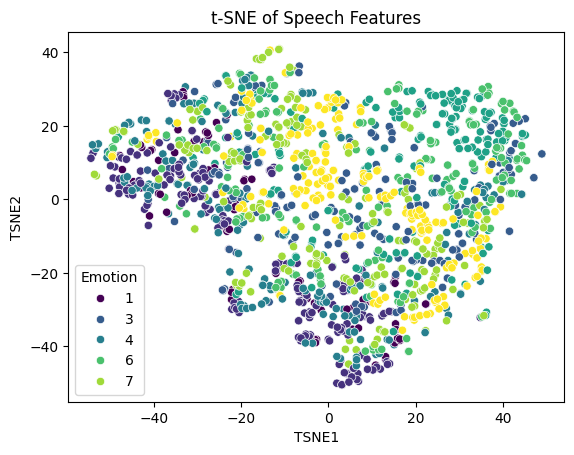

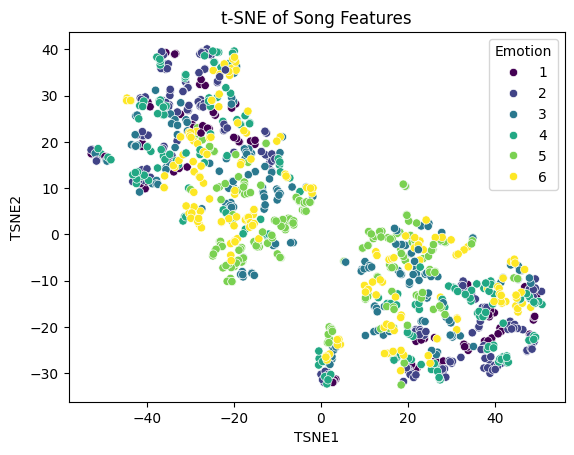

In [29]:
scaler_speech = StandardScaler()
x_speech_scaled = scaler_speech.fit_transform(x_speech)

scaler_song = StandardScaler()
x_song_scaled = scaler_song.fit_transform(x_song)

pca_speech = PCA(n_components=2)
pca_speech_result = pca_speech.fit_transform(x_speech_scaled)
pca_speech_df = pd.DataFrame(data=pca_speech_result, columns=['PCA1', 'PCA2'])
pca_speech_df['Label'] = y_speech

pca_song = PCA(n_components=2)
pca_song_result = pca_song.fit_transform(x_song_scaled)
pca_song_df = pd.DataFrame(data=pca_song_result, columns=['PCA1', 'PCA2'])
pca_song_df['Label'] = y_song

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=pca_speech_df, palette='viridis')
plt.title('PCA of Speech Features')
plt.legend(title='Emotion')
plt.show()

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=pca_song_df, palette='viridis')
plt.title('PCA of Song Features')
plt.legend(title='Emotion')
plt.show()

tsne_speech = TSNE(n_components=2, random_state=42)
tsne_speech_result = tsne_speech.fit_transform(x_speech_scaled)
tsne_speech_df = pd.DataFrame(data=tsne_speech_result, columns=['TSNE1', 'TSNE2'])
tsne_speech_df['Label'] = y_speech

tsne_song = TSNE(n_components=2, random_state=42)
tsne_song_result = tsne_song.fit_transform(x_song_scaled)
tsne_song_df = pd.DataFrame(data=tsne_song_result, columns=['TSNE1', 'TSNE2'])
tsne_song_df['Label'] = y_song

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_speech_df, palette='viridis')
plt.title('t-SNE of Speech Features')
plt.legend(title='Emotion')
plt.show()

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_song_df, palette='viridis')
plt.title('t-SNE of Song Features')
plt.legend(title='Emotion')
plt.show()


## Filename identifiers 

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_speech, y_speech)
print(x_train.shape)
print(y_train.shape)

x_train_norm = normalization(x_train, np.mean(x_train, axis=0), np.std(x_train, axis=0))
x_test_norm = normalization(x_test, np.mean(x_train, axis=0), np.std(x_train, axis=0))
print(x_train_norm.shape)
print(x_test_norm.shape)


(1092, 88)
(1092,)
(1092, 88)
(364, 88)


## Random Forest

In [10]:
num_trees = range(50, 200)
tree_model_accuracy = []
for n in num_trees:
    random_forest = RandomForestClassifier(n_estimators=n, random_state= 32)
    random_forest.fit(x_train, y_train)
    y_predict = random_forest.predict(x_test)
    acc = accuracy_score(y_test, y_predict)
    tree_model_accuracy.append(acc)


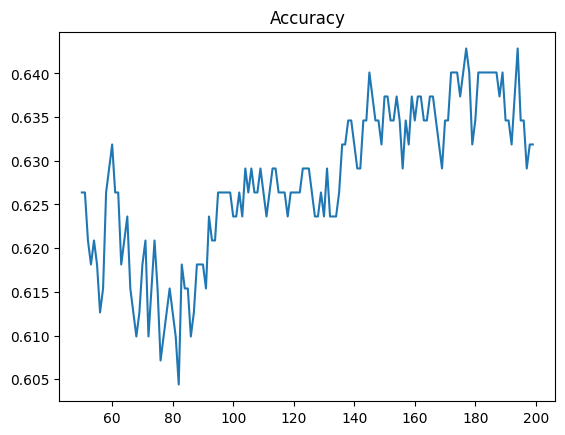

In [14]:
plt.plot(range(50, 200), tree_model_accuracy)
plt.title("Accuracy")
plt.show()

In [31]:
random_forest = RandomForestClassifier( random_state= 32)
random_forest.fit(x_train, y_train)
y_predict = random_forest.predict(x_test)
acc = accuracy_score(y_test, y_predict)
print(f" trees --> Accuracy {acc}")

conf_matrix = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_predict))


 trees --> Accuracy 0.5769230769230769
Confusion Matrix:
[[ 8 12  2  1  0  1  1  0]
 [ 1 47  0  3  0  0  0  0]
 [ 0  1 28  1  3  6  2 10]
 [ 1  9  4 21  0  5  5  2]
 [ 0  0  4  3 32  0  8  8]
 [ 1  2  4  4  7 19  2  5]
 [ 4  5  5  3  0  1 27  4]
 [ 1  0  4  2  4  3  0 28]]

Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      0.32      0.39        25
         2.0       0.62      0.92      0.74        51
         3.0       0.55      0.55      0.55        51
         4.0       0.55      0.45      0.49        47
         5.0       0.70      0.58      0.63        55
         6.0       0.54      0.43      0.48        44
         7.0       0.60      0.55      0.57        49
         8.0       0.49      0.67      0.57        42

    accuracy                           0.58       364
   macro avg       0.57      0.56      0.55       364
weighted avg       0.58      0.58      0.57       364



In [15]:
class MLPAutoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(MLPAutoencoder, self).__init__()
        #self.flatten = nn.Flatten()
        self.encoder = nn.Linear(88, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, 88)
        #self.unflatten = torch.nn.Unflatten(1, 88)

    def forward(self, x):
        #x = self.flatten(x)
        out = F.relu(self.encoder(x))
        out = torch.sigmoid(self.decoder(out))
        return out
    
    def get_embedding(self, x):
        #x = self.flatten(x)
        return F.relu(self.encoder(x))
d = torch.from_numpy(x_train)
print(d.shape)
print(nn.Flatten(d))
print(d[0].shape)
print(d)
print(d.dtype)

torch.Size([1092, 88])
Flatten(
  start_dim=tensor([[ 3.0111e+01,  1.0573e-01,  2.8863e+01,  ...,  6.7000e-01,
            3.8944e-01, -3.6404e+01],
          [ 3.2195e+01,  2.1289e-02,  3.1728e+01,  ...,  3.6333e-01,
            4.4380e-01, -5.0949e+01],
          [ 2.5107e+01,  1.1781e-01,  2.2187e+01,  ...,  4.0167e-01,
            4.1994e-01, -4.7011e+01],
          ...,
          [ 3.6546e+01,  9.8959e-02,  3.3611e+01,  ...,  5.2500e-01,
            4.6554e-01, -3.8321e+01],
          [ 2.4759e+01,  1.0541e-01,  2.2685e+01,  ...,  5.1500e-01,
            4.5069e-01, -4.5371e+01],
          [ 3.2421e+01,  4.2314e-02,  3.1213e+01,  ...,  6.7333e-01,
            3.8474e-01, -4.3369e+01]], dtype=torch.float64), end_dim=-1
)
torch.Size([88])
tensor([[ 3.0111e+01,  1.0573e-01,  2.8863e+01,  ...,  6.7000e-01,
          3.8944e-01, -3.6404e+01],
        [ 3.2195e+01,  2.1289e-02,  3.1728e+01,  ...,  3.6333e-01,
          4.4380e-01, -5.0949e+01],
        [ 2.5107e+01,  1.1781e-01,  2.2187

In [16]:
model = MLPAutoencoder(33).double()
pred = model(d)


100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


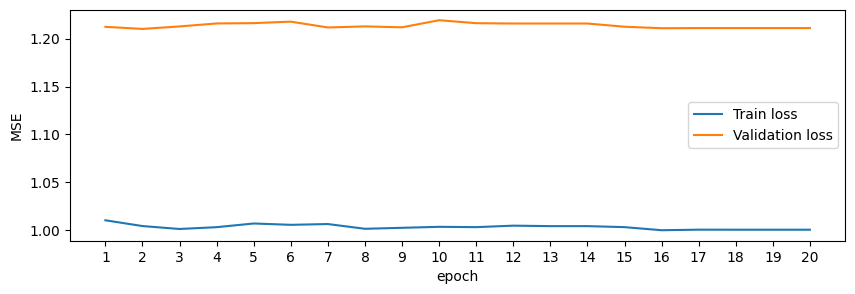

In [17]:
LR = 0.1
device = "cpu"
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

n_epochs = 20
model.to(device)
t_losses, v_losses = [], []
x_train_tensor = torch.from_numpy(x_train_norm)
x_test_tensor = torch.from_numpy(x_test_norm)

for epoch in tqdm(range(1, n_epochs+1)):
    # Training
    train_loss = 0.0
    for (X, y) in zip(x_train_tensor, y_train):
        X = torch.squeeze(X).to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, X)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
            
    # Eval        
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (X, y) in zip(x_test_tensor, y_test):
            X = torch.squeeze(X).to(device)
            outputs = model(X)
            loss = criterion(outputs, X)
            test_loss += loss.item()        
            
    train_loss = train_loss/len(x_train)
    test_loss = test_loss/len(x_test)
    t_losses.append(train_loss)
    v_losses.append(test_loss)
    
plt.figure(figsize=(10,3))
plt.plot(np.arange(1,len(t_losses)+1), t_losses, label='Train loss')
plt.plot(np.arange(1,len(v_losses)+1),v_losses, label='Validation loss')
plt.xticks(np.arange(1,len(t_losses)+1))
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Redes neuronales

## CNN

In [47]:
def process_dataset(data_path):#, save_path):

    files = glob(data_path)

    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    extracted_features = smile.process_files(files)

    # x_ = extracted_features.values
    # y_ = np.array([int(os.path.basename(path).split('-')[2]) for path in files])

    return extracted_features

dataset = process_dataset(speech_unprocessed_path)
print(dataset)

                                                                                     F0semitoneFrom27.5Hz_sma3nz_amean  \
file                                               start  end                                                            
data/Audio_Speech_Actors_01-24\Actor_01\03-01-0... 0 days 0 days 00:00:03.303291667                          24.263884   
data/Audio_Speech_Actors_01-24\Actor_01\03-01-0... 0 days 0 days 00:00:03.336666667                          25.167889   
data/Audio_Speech_Actors_01-24\Actor_01\03-01-0... 0 days 0 days 00:00:03.269916667                          24.186604   
data/Audio_Speech_Actors_01-24\Actor_01\03-01-0... 0 days 0 days 00:00:03.169833333                          24.268761   
data/Audio_Speech_Actors_01-24\Actor_01\03-01-0... 0 days 0 days 00:00:03.536854167                          24.898132   
...                                                                                                                ...   
data/Audio_Speech_Actors

In [50]:
print(dataset.columns)

Index(['F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma3_stddevNorm', 'mfcc2_

In [38]:
class CNN_X(Model):
    def __init__(self):
        super(CNN_X, self).__init__()
        self.conv1 = Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1))
        self.avgpool1 = AveragePooling2D(pool_size=(2, 2))
        self.conv2 = Conv2D(16, kernel_size=(3, 3), activation='relu')
        self.avgpool2 = AveragePooling2D(pool_size=(2, 2))
        self.conv3 = Conv2D(32, kernel_size=(3, 3), activation='relu')
        self.avgpool3 = AveragePooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.fc1 = Dense(2048, activation='relu')
        self.fc2 = Dense(2048, activation='relu')
        self.fc3 = Dense(8, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.avgpool2(x)
        x = self.conv3(x)
        x = self.avgpool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)

# le pasamos las features espectrales de arriba (MFCC)

c:\Users\casti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'cnn_x_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "cnn_x_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)